Lambda School Data Science, Unit 2: Predictive Modeling

# Applied Modeling, Module 4

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [X] Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- [ ] Make a Shapley force plot to explain at least 1 individual prediction.
- [ ] Share at least 1 visualization on Slack.

(If you haven't completed an initial model yet for your portfolio project, then do today's assignment using your Tanzania Waterpumps model.)

## Stretch Goals
- [ ] Make Shapley force plots to explain at least 4 individual predictions.
    - If your project is Binary Classification, you can do a True Positive, True Negative, False Positive, False Negative.
    - If your project is Regression, you can do a high prediction with low error, a low prediction with low error, a high prediction with high error, and a low prediction with high error.
- [ ] Use Shapley values to display verbal explanations of individual predictions.
- [ ] Use the SHAP library for other visualization types.

The [SHAP repo](https://github.com/slundberg/shap) has examples for many visualization types, including:

- Force Plot, individual predictions
- Force Plot, multiple predictions
- Dependence Plot
- Summary Plot
- Summary Plot, Bar
- Interaction Values
- Decision Plots

We just did the first type during the lesson. The [Kaggle microcourse](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values) shows two more. Experiment and see what you can learn!


## Links
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)

In [19]:
import sys, getpass
a = getpass.getuser()
### example appending of folder
# A
sys.path.append('/home/{}/Code/Github-Repos/BFLibrary/'.format(a))
# B
sys.path.append('/Users/{}/Programs/BFLibrary/'.format(a))
#from BFLibrary import ACompass, BWarp, CToolbox 
import AMap as am
import BCook as bc
import CTools as ct

In [20]:
import pandas as pd
pd.options.display.float_format = None
#df = pd.read_excel('~/Downloads/CoralBleaching.xlsm')
df = pd.read_excel('/home/{}/Code/ML/CoralBleaching.xlsm'.format(a))

In [21]:
target = 'BLEACHING_SEVERITY'
def wrangle(df):
    # Let's group by bleaching or not.
    df[target] = df[target].replace({
        'Low':1, 'HIGH':1, 'Medium':1, 'Severity Unknown':1,
        'No Bleaching':0})
    ### ID 29433 LAT is actually -10.269
    df['LAT'] = df['LAT'].replace({-10269:-10.269})
    features, num_feats, cat_feats = bc.pantryFeatures(df)
    
    ### Drop some columns w/ almost no values
    df = bc.diceBadCols(df, features, percent=60)
    
    return df
df = wrangle(df)

In [22]:
# Split into train test and val by year.
test_mask = (df['YEAR'] > 2005)
val_mask = (
    (df['YEAR'] > 2003) &
    (df['YEAR'] <= 2005)
)
train_mask = (df['YEAR'] <= 2003)
# Assign masks
test = df[test_mask]
train = df[train_mask]
val = df[val_mask]

# Just to see if they are the right shapes.
print(train.shape, val.shape, test.shape,"\n",
      "Sum of shapes:", train.shape[0]+val.shape[0]+test.shape[0],"\n",
      "Total dataframe shape:", df.shape[0])

(4167, 15) (965, 15) (1058, 15) 
 Sum of shapes: 6190 
 Total dataframe shape: 6190


In [23]:
# Get features from train after I chopped em'
features, _, _ = bc.pantryFeatures(train)
X_train = train[features].drop(target,axis=1)
y_train = train[target]
X_val = val[features].drop(target,axis=1)
y_val = val[target]
X_test = test[features].drop(target,axis=1)
y_test = test[target]

In [24]:
# Save IDs like Ryans to look up results,
# to compare w/ predicted results
train_id = X_train['ID']
val_id = X_val['ID']
test_id = test['ID']

X_train.drop('ID', axis=1, inplace=True)
X_val.drop('ID', axis=1, inplace=True)
X_test.drop('ID', axis=1, inplace=True)

In [25]:
print(X_train.shape, y_train.shape, "\n",
      X_val.shape, y_train.shape, "\n",
      X_test.shape, y_test.shape)

(4167, 13) (4167,) 
 (965, 13) (4167,) 
 (1058, 13) (1058,)


In [26]:
# Majority class baseline
y_train.value_counts(normalize=True)

1    0.75594
0    0.24406
Name: BLEACHING_SEVERITY, dtype: float64

In [27]:
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

In [28]:
from pdpbox.pdp import pdp_plot, pdp_isolate
from pdpbox import pdp

features, _, _ = bc.pantryFeatures(X_train)
encoder = ce.OrdinalEncoder()
X_encoded = encoder.fit_transform(X_train)
X_encoded = X_encoded.fillna(0)
model = RandomForestClassifier(
    n_estimators=20, 
    random_state=4, 
    n_jobs=-1
)
model.fit(X_encoded,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
                       oob_score=False, random_state=4, verbose=0,
                       warm_start=False)

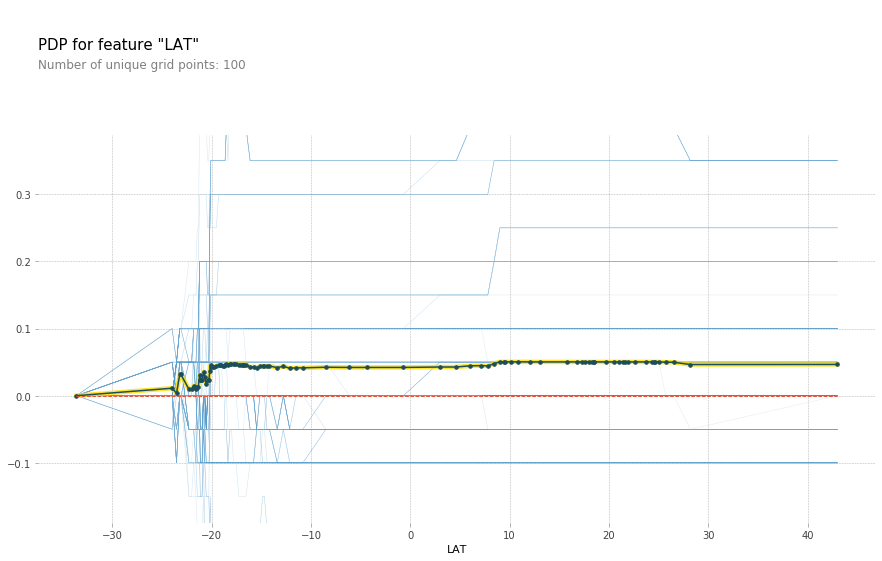

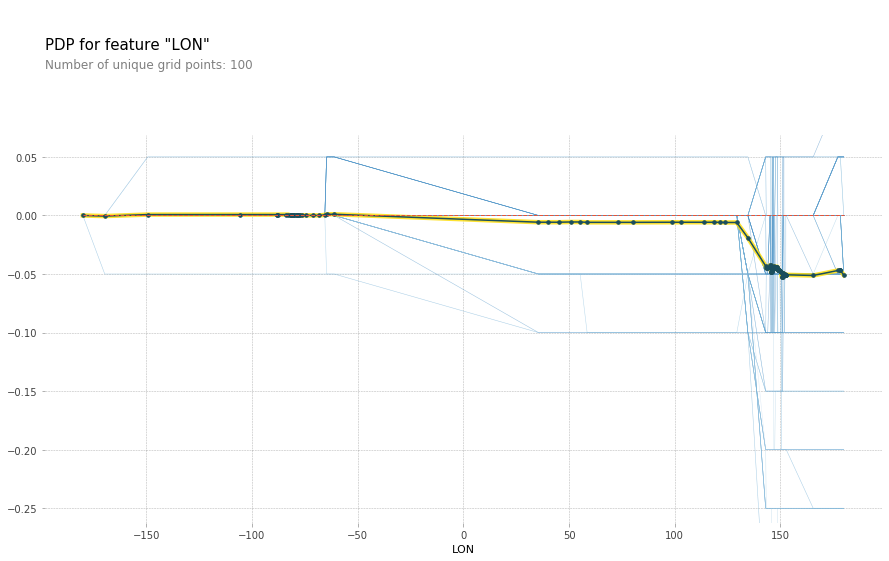

In [30]:
# using pdpbox
%matplotlib inline
import matplotlib.pyplot as plt
from pdpbox import pdp
feature = features
for n in range(0, 1):
    f = feature[n]
    pdp_dist = pdp.pdp_isolate(
        model=model, 
        dataset=X_encoded, 
        model_features=features, 
        feature=f,
        num_grid_points=100
    )
    
    pdp.pdp_plot(pdp_dist, feature_name=f, plot_lines=True, frac_to_plot=100);
    plt.show() 

In [32]:
from xgboost import XGBClassifier

processor = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median')
)
X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

e_set = [(X_train_processed, y_train),
         (X_val_processed, y_val)]
model = XGBClassifier(n_estimators=500, n_jobs=-1)
# Eval_metric seems to give roc auc :investigate:
model.fit(X_train_processed, y_train, 
          eval_set=e_set, eval_metric='auc',
          early_stopping_rounds=10)

[0]	validation_0-auc:1	validation_1-auc:1
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:1	validation_1-auc:1
[2]	validation_0-auc:1	validation_1-auc:1
[3]	validation_0-auc:1	validation_1-auc:1
[4]	validation_0-auc:1	validation_1-auc:1
[5]	validation_0-auc:1	validation_1-auc:1
[6]	validation_0-auc:1	validation_1-auc:1
[7]	validation_0-auc:1	validation_1-auc:1
[8]	validation_0-auc:1	validation_1-auc:1
[9]	validation_0-auc:1	validation_1-auc:1
[10]	validation_0-auc:1	validation_1-auc:1
Stopping. Best iteration:
[0]	validation_0-auc:1	validation_1-auc:1



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [34]:
X_test.columns, X_train.columns

(Index(['LAT', 'LON', 'MONTH', 'YEAR', 'SEVERITY_CODE', 'REGION', 'SUBREGION',
        'COUNTRY', 'LOCATION', 'DEPTH', 'REMARKS', 'SOURCE', 'COUNTRY_CODE'],
       dtype='object'),
 Index(['LAT', 'LON', 'MONTH', 'YEAR', 'SEVERITY_CODE', 'REGION', 'SUBREGION',
        'COUNTRY', 'LOCATION', 'DEPTH', 'REMARKS', 'SOURCE', 'COUNTRY_CODE'],
       dtype='object'))

In [35]:
X_test_processed = processor.transform(X_test)
y_pred_proba = model.predict_proba(X_test_processed)[:, 1]
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

ROC AUC: 1.0


In [53]:
df = pd.DataFrame({
    'ID': test_id,
    'pred_proba': y_pred_proba,
    'status_group': y_test
})

df = df.merge( 
    train[['ID','LAT','LON','MONTH','YEAR','SEVERITY_CODE','REGION',
           'SUBREGION','COUNTRY','LOCATION','DEPTH','REMARKS','SOURCE','COUNTRY_CODE']],
    how='left'
)

In [54]:
print(df.shape)
X_train.head()

(1058, 16)


,LAT,LON,MONTH,YEAR,SEVERITY_CODE,REGION,SUBREGION,COUNTRY,LOCATION,DEPTH,REMARKS,SOURCE,COUNTRY_CODE
3,43.0000,5.0000,8.0,1999,-1,NaN,NaN,France,SE France,NaN,Bleaching of Cladocora caespitosa and Oculina ...,Martin Pêcheux (martin-pecheux@wanadoo.fr) per...,FRA
6,16.0000,-95.0000,5.0,1998,3,NaN,NaN,Mexico (Pacific),"Tijera and Mazunte, Oaxaca",NaN,"In spring and summer 1998, when the anti-El Ni...","Reyes-Bonilla, et al 2002. Effects of the El ...",MEX_PAC
7,9.2723,-82.0065,6.0,2002,2,NaN,NaN,Panama (Atlantic),"Cayos Zapatilla A, Archipielago de Bocas del Toro",12m,Live stony coral cover 28%. \n23% of stony co...,Coral List:30/7/2002: Marilyn Brandt,PAN_ATL
8,17.7900,-64.6300,NaN,1998,2,NaN,NaN,St. Croix,"Buck Island, US Virgin Islands",NaN,bleaching,GCRMN 2000. Chapter 14,VIR_CRO
9,17.6840,-64.7390,9.0,1987,1,NaN,NaN,St. Croix,Cane Bay,8-10m,"23.2% of coral cover was pale, 5.8% bleached (...","Lang, J.C., H.R. Lasker, E.H. Gladfelter, P. H...",VIR_CRO


In [49]:
import shap

row = X_test.iloc[[105]]

explainer = shap.TreeExplainer(model)
row_processed = processor.transform(row)

# How each feature added up to final prediction
shap_values = explainer.shap_values(row_processed)

# omg js
shap.initjs()
shap.force_plot(
    # What we predict by default
    base_value=explainer.expected_value,
    # The nudgers
    shap_values=shap_values,
    # Just the row to use feature names/values
    features=row
)